# March Data Crunch Madness #

**Goal**

   Use Machine Learning and Statistics to predict winners of NCAA tournament games based on season performance
   
**Method**
    
   This project uses aggregated regular season stats to calculate each team's skill for that metric, then compares the ratio for team 1 and team 2 to predict if team 1 will win.
   
   To reduce noise, regular season games are only included if they are against teams that went on to make the tournament that year.  For example, if UNC played Duke and scored 86 points, this is a good indication of how they will perform against the type of teams they will face in the tournament.  However if they play Radford and score 95, we should not include the 95 points in their average score because they are unlikely to play a team with such a bad defense in the post season.  This applies to all team stats except for Tempo, Offensive Efficiency, and Defensive Efficiency (we could not get game level for these).  
   
   The aggregating occurs in excel and the values are the average performance for that stat against quality opponents.  The ratio between team 1 and team 2's metrics are used as training and testing data for our classifiers.  The standard model used for sports analysis is logistic regression.  We will test out a few others.  Our final model is an ensemble voting classifier that combines the outputs of logistic regression, support vector machine, neural network, and adaptive boosting to provide and ultimate prediction.
   
**Results**
   
   The final results give about a 74% accuracy in historical predictions for each game that occurred.  While this threshold would not be satisfactory for some enterprise models, it is pretty good for sports predictions.  Especially considering that we lack player level data to account for injuries etc.  
   
   The results for the 2017 tournament are a little **75%**.  The overperformance is due to the relatively low upset count this year (the model is very reliant on seed as a predictor).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import random
import itertools
import seaborn as sns
import warnings


warnings.filterwarnings("ignore")
sns.set(style = 'darkgrid')
% matplotlib inline

In [2]:
games = pd.read_excel('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\Test Data\\New.xlsx', sheet = 'Sheet1')

In [3]:
games_r = games.ix[:,5:] #extract only the ratio columns
games_r.columns

Index(['r_seeddiff', 'r_win%', 'r_seed', 'r_1rpi', 'r_adjseed', 'r_1adjrpi',
       'r_ascore', 'r_agscore', 'r_Av fg%', 'r_Av fg3%', 'r_Av ft%', 'r_1or',
       'r_1dr', 'r_1ast', 'r_1to', 'r_1stl', 'r_1blk', 'r_1pf', 'r_Av 2fg%',
       'r_Av 2fg3%', 'r_Av 2ft%', 'r_2or', 'r_2dr', 'r_2ast', 'r_2to',
       'r_2stl', 'r_2blk', 'r_2pf', 'r_tempo', 'r_adjtempo', 'r_oe', 'r_adjoe',
       'r_de', 'r_adjde'],
      dtype='object')

In [4]:
feats = ['r_seed',
 'r_1rpi',
 'r_adjde',
 'r_1adjrpi',
 'r_1dr',
 'r_Av 2ft%',
 'r_2or',
 'r_1ast',
 'r_oe',
 'r_ascore',
 'r_adjseed',
 'r_Av fg%']

games_r['upset'] = games['upset']

season = games_r[feats]#[['r_seeddiff','r_seed','r_1rpi','r_adjseed','r_1adjrpi','upset','r_adjtempo','r_adjde']]


X = season
y = games_r['upset']

#X=X.drop('upset',axis = 1)

#season=season.drop('upset',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

uscaler = StandardScaler() 

uscaler.fit(X_train)  
X_train = uscaler.transform(X_train)  

X_test = uscaler.transform(X_test)  

X = uscaler.transform(X)
#Adaptive Boosting
ada = AdaBoostClassifier(DecisionTreeClassifier(criterion = 'entropy',max_depth=4),n_estimators=1,learning_rate=4)

ada_pred = ada.fit(X_train,y_train).predict(X_test)
print('ada',ada.score(X_train,y_train), ada.score(X_test,y_test), ada.score(X_train,y_train)-ada.score(X_test,y_test))

# Gaussian NB 
gauss = GaussianNB()
gauss_pred = gauss.fit(X_train, y_train).predict(X_test)
print('gauss',gauss.score(X_train,y_train), gauss.score(X_test,y_test), gauss.score(X_train,y_train)-gauss.score(X_test,y_test))

###Neural Net
nn = MLPClassifier(solver='adam', activation = 'logistic',hidden_layer_sizes=(10, 50), random_state=1)
nn_pred = nn.fit(X_train,y_train).predict(X_test)
print('nn',nn.score(X_train,y_train), nn.score(X_test,y_test), nn.score(X_train,y_train)-nn.score(X_test,y_test))

###LogReg
lr = LogisticRegression(penalty = 'l2', dual = True)
lr_pred = lr.fit(X_train, y_train).predict(X_test)
print('lr',lr.score(X_train,y_train), lr.score(X_test, y_test),lr.score(X_train,y_train)-lr.score(X_test,y_test))

#Ensemble#
ensu = VotingClassifier(estimators=[('Ada', ada), ('Gauss', gauss), ('LogReg',lr), ('NN',nn)], 
                       voting='soft', weights=[7,1,1,1])
ens_pred = ensu.fit(X_train, y_train).predict(X_test)
print('ens',ensu.score(X_train,y_train), ensu.score(X_test,y_test), ensu.score(X_train,y_train)-ensu.score(X_test,y_test))

print(confusion_matrix(y_test,ens_pred))

ens_target = pd.DataFrame(ensu.predict_proba(X),columns = ['predicted','inverse'])
#games['upset_pred'] = ens_target['inverse']

def predupset(df):
    if df['upset_pred'] >= 0.5:
        return 1
    else:
        if df['r_seed'] < 1.05:
            return 1
        elif df['r_seed'] >= 1.05:
            return 0
        
def predmatch(df):
    if df['game_pred'] == df['result']:
        return 1
    else:
        return 0

upset = games
upset['upset_pred'] = ens_target['inverse']
upset['game_pred'] = upset.apply(predupset,axis = 1)

ada 0.878267973856 0.879139072848 -0.000871098991473
gauss 0.698529411765 0.715231788079 -0.0167023763148
nn 0.859477124183 0.872516556291 -0.0130394321084
lr 0.858660130719 0.864238410596 -0.00557827987707
ens 0.877450980392 0.872516556291 0.00493442410077
[[512  15]
 [ 62  15]]


In [5]:
games_r = games.ix[:,5:] #extract only the ratio columns
#games_r['upset'] = games['Upset']
games_r['result'] = games['result']
games_r.shape

(1828, 37)

Scaling the seed and distance ratios (when a 16 seed plays a 1 seed it skews the data)

This is just for the violinplot, it will be scaled for real later

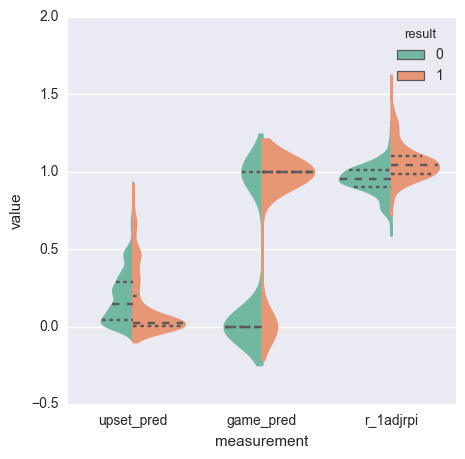

In [6]:
temp = games[['result','upset_pred','game_pred','r_1adjrpi']]
#temp['R_dist'] = np.log1p(games['R_dist'])
#temp['r_seed'] = np.log1p(games['r_seed'])

m_r = pd.melt(temp, "result", var_name="measurement")
fig, ax = plt.subplots(figsize=(5,5))
p = sns.violinplot(ax=ax, x="measurement", y="value", hue="result", split = True, data=m_r, inner = 'quartile', palette = 'Set2');

Extract only seasonal calculations that we have good measures for

In [7]:
season = games_r
season_f = games_r
season_f['result'] = games_r['result']
season_f.head(1)

,r_seeddiff,r_win%,r_seed,r_1rpi,r_adjseed,r_1adjrpi,r_ascore,r_agscore,r_Av fg%,r_Av fg3%,...,r_2pf,r_tempo,r_adjtempo,r_oe,r_adjoe,r_de,r_adjde,upset_pred,game_pred,result
0,0.030769,0.0,1.0,0.800327,0.969231,1.047446,1.020115,1.144033,0.909091,0.718391,...,1.358974,0.981175,0.994728,0.98591,1.03916,1.10581,1.059968,0.037386,1,1


Shows the relationship between the Adjusted RPI and the stock RPI

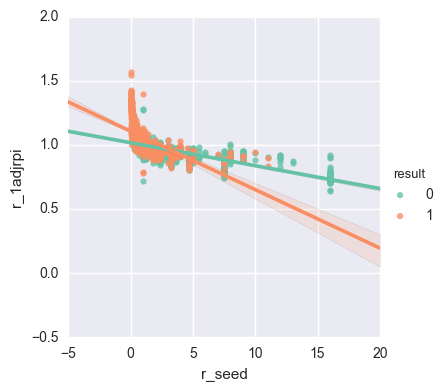

In [8]:
sns.lmplot(x = 'r_seed', y = 'r_1adjrpi',  hue='result', size = 4, data = season_f, palette = 'Set2');

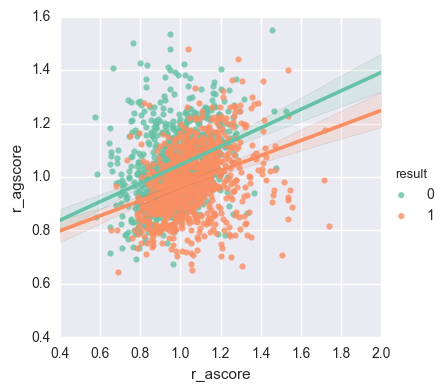

In [9]:
sns.lmplot(x = 'r_ascore', y = 'r_agscore',  hue='result', size = 4, data = season_f, palette = 'Set2');

In [10]:
X = season
y = season_f['result']
#X=X.drop(['result','r_1rpi','r_1adjrpi'],axis = 1)
X=X.drop('result',axis = 1)
X.head()

,r_seeddiff,r_win%,r_seed,r_1rpi,r_adjseed,r_1adjrpi,r_ascore,r_agscore,r_Av fg%,r_Av fg3%,...,r_2blk,r_2pf,r_tempo,r_adjtempo,r_oe,r_adjoe,r_de,r_adjde,upset_pred,game_pred
0,0.030769,0.000000,1.000000,0.800327,0.969231,1.047446,1.020115,1.144033,0.909091,0.718391,...,0.729167,1.358974,0.981175,0.994728,0.985910,1.039160,1.105810,1.059968,0.037386,1
1,0.046107,0.833333,0.062500,1.372294,0.016393,1.320912,1.412429,1.170699,0.941498,0.640625,...,0.861111,1.685897,1.165885,1.136351,1.074721,1.143657,0.956134,0.918630,0.003128,1
2,-0.047619,0.500000,1.428571,1.124272,1.476190,0.980125,0.944023,1.048039,1.091314,1.177500,...,0.842857,0.930636,0.987478,0.981218,1.028678,1.007868,1.059327,1.034759,0.683779,1
3,-0.872549,0.700000,1.833333,0.994787,2.705882,0.974465,0.891969,1.053972,0.866056,1.290433,...,1.430428,0.990568,1.048828,1.039785,0.957857,0.989673,1.085490,1.037358,0.494298,0
4,0.118056,2.000000,0.888889,0.951907,0.770833,1.048964,1.081340,1.011765,1.052773,1.013929,...,0.827586,1.021978,1.040799,1.018211,0.978464,0.984121,0.975844,0.973060,0.044878,1


In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt_pred = dt.fit(X,y)
i = list(dt.feature_importances_)
t = list(X.columns)

imp = pd.DataFrame(columns = ['feature','score'])
imp['feature'] = t
imp['score'] = i
feats = imp.sort(columns = 'score', ascending = False)
feats = list(feats['feature'])
print(imp.sort(columns = 'score', ascending = False))


       feature     score
35   game_pred  0.189772
2       r_seed  0.057020
33     r_adjde  0.054451
34  upset_pred  0.054204
3       r_1rpi  0.051928
31     r_adjoe  0.037237
1       r_win%  0.032473
24       r_2to  0.030759
12       r_1dr  0.030504
16      r_1blk  0.028960
27       r_2pf  0.026921
13      r_1ast  0.026739
25      r_2stl  0.026560
20   r_Av 2ft%  0.025866
8     r_Av fg%  0.024374
23      r_2ast  0.023589
6     r_ascore  0.022264
21       r_2or  0.021539
15      r_1stl  0.019631
14       r_1to  0.019158
10    r_Av ft%  0.017925
19  r_Av 2fg3%  0.017415
26      r_2blk  0.016803
28     r_tempo  0.016370
22       r_2dr  0.015582
5    r_1adjrpi  0.014670
7    r_agscore  0.013141
9    r_Av fg3%  0.012406
18   r_Av 2fg%  0.012393
30        r_oe  0.012351
0   r_seeddiff  0.011117
29  r_adjtempo  0.008404
17       r_1pf  0.007828
11       r_1or  0.007470
4    r_adjseed  0.006329
32        r_de  0.005846


Split Train and Test data 67/33

Train a scaler based on the Training data and apply it to the test and training set to improve model performance

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scalerclust = StandardScaler() 

scalerclust.fit(X_train)  
X_train = scalerclust.transform(X_train)  

X_test = scalerclust.transform(X_test)  

Train Kmeans model

Fit test set and use that to evaluate win percentage per cluster

In [13]:
kmeans = KMeans(n_clusters = 5, random_state = 0,init='k-means++',max_iter = 100)

kmeans_pred = kmeans.fit(X_train)
x1 = X
x1 = scalerclust.transform(x1)
clust = kmeans.predict(x1)
X['Clust'] = clust
list(set(clust))

[0, 1, 2, 3, 4]

In [14]:
labs = pd.read_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\2017\\col header.csv')
labels = list(labs['\ufefflabs'])
labels.append('Upset Pred')
labels.append('Game Pred')
labels.append('Cluster')
labels.append('Result')

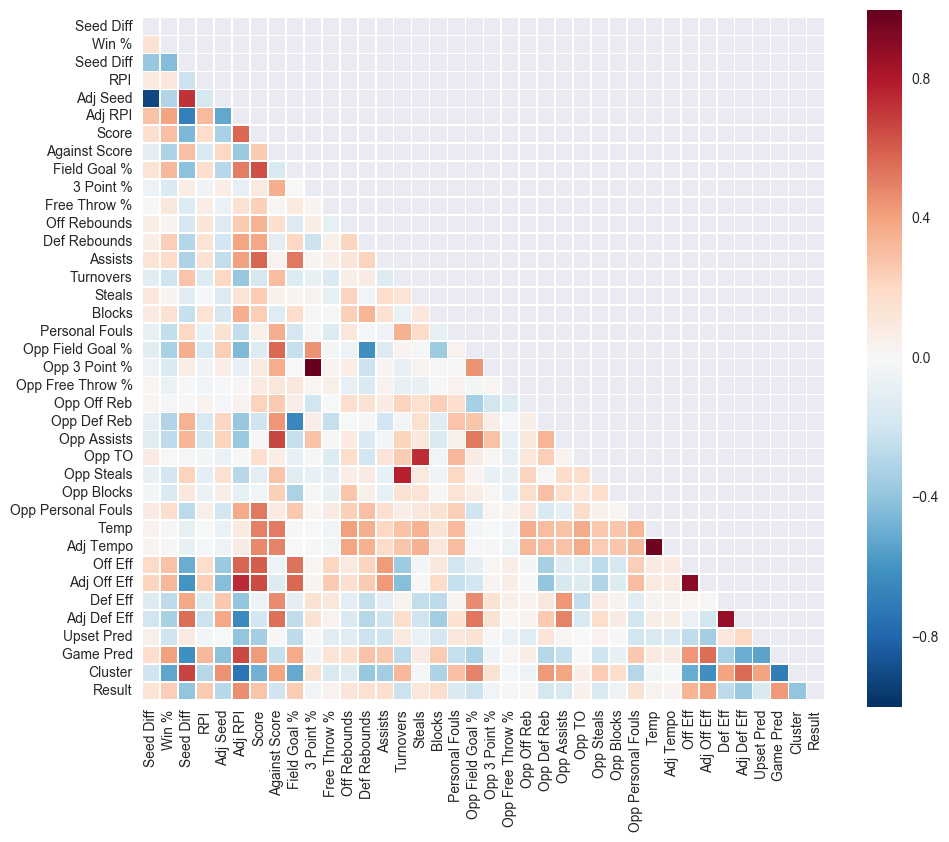

In [15]:
x1 = X
x1['result'] = season_f['result']
corr = X.corr()
fg, ax = plt.subplots(figsize = (11,9))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

p = sns.heatmap(corr, mask = mask, linewidths = .5, square = True, xticklabels = labels[5:], yticklabels = labels[5:]);

In [16]:
pd.pivot_table(x1,values = 'result',index = 'Clust', aggfunc = np.mean)

Clust
0    0.744726
1    0.599147
2    0.395387
3    0.071429
4    0.156780
Name: result, dtype: float64

In [17]:
pd.pivot_table(x1,values = 'result',index = 'Clust', aggfunc = 'count')

Clust
0    474
1    469
2    607
3     42
4    236
Name: result, dtype: int64

Split Train and Test data 67/33

Train a scaler based on the Training data and apply it to the test and training set to improve model performance

In [18]:
X = X.drop('result',axis = 1) 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler() 
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [20]:
X_train.shape

(1224, 37)

In [21]:
xx = scaler.transform(X)

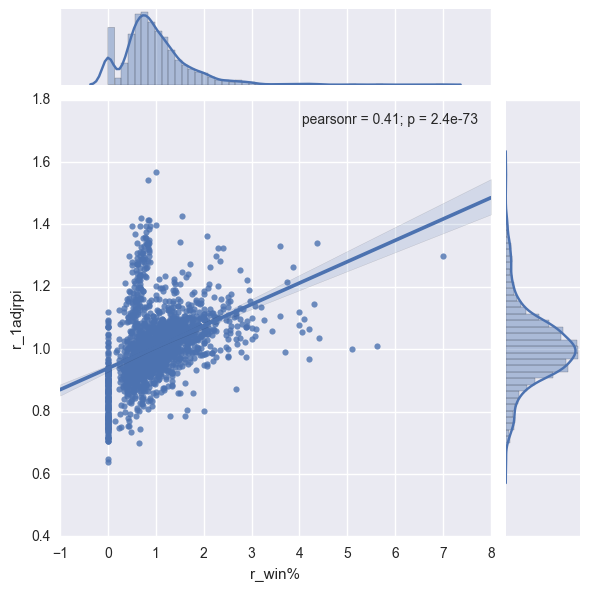

In [22]:
sns.jointplot(x = 'r_win%', y = 'r_1adjrpi', data=x1, kind="reg");

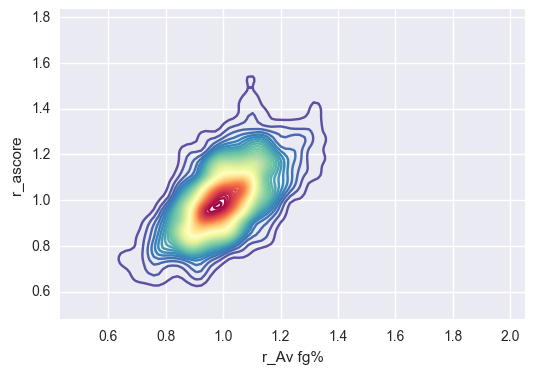

In [23]:
sns.kdeplot(x1["r_Av fg%"], x1["r_ascore"],cmap = 'Spectral_r', n_levels = 50);

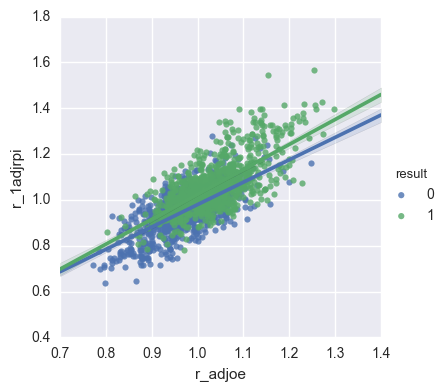

In [24]:
sns.lmplot(x = 'r_adjoe', y = 'r_1adjrpi',  hue='result', size = 4, data = x1);

Capture model stats

In [25]:
m_eval = pd.DataFrame(columns = ['method','trainscore','testscore','True Positive','True Negative'])

In [26]:
def addeval(method, train, test, tpos, tneg):
    global m_eval
    d = pd.DataFrame([[method, train, test, tpos, tneg]],columns = ['method','trainscore','testscore','True Positive','True Negative'])
    m_eval = m_eval.append(d)

**All Confusion Matrices have predicted values [0,1] on the vertical axis, and true values [0,1] on the horizonal axis**

# Logistic Regression#

In [27]:
###LogReg
lr = LogisticRegression(penalty = 'l2', dual = True)
lr_pred = lr.fit(X_train, y_train).predict(X_test)
lr.score(X_train,y_train), lr.score(X_test, y_test),lr.score(X_train,y_train)-lr.score(X_test,y_test)

(0.73774509803921573, 0.73675496688741726, 0.00099013115179846789)

In [28]:
mtrx = confusion_matrix(y_test,lr_pred)
mtrx

array([[217,  89],
       [ 70, 228]])

In [29]:
addeval('Log Reg',lr.score(X_train,y_train), lr.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# SVC

In [30]:
###SVC
svc = SVC(kernel = 'linear',C=10, gamma=0.01, probability = True)
svc_pred = svc.fit(X_train, y_train).predict(X_test)
svc.score(X_train,y_train), svc.score(X_test, y_test),svc.score(X_train,y_train)-svc.score(X_test,y_test)

(0.72058823529411764, 0.70695364238410596, 0.013634592910011678)

In [31]:
mtrx = confusion_matrix(y_test,svc_pred)
mtrx

array([[191, 115],
       [ 62, 236]])

In [32]:
addeval('SVC',svc.score(X_train,y_train), svc.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Neural Net

In [33]:
###Neural Net
nn = MLPClassifier(solver='adam', activation = 'logistic',hidden_layer_sizes=(10, 50), random_state=1)

nn_pred = nn.fit(X_train,y_train).predict(X_test)
nn.score(X_train,y_train), nn.score(X_test,y_test), nn.score(X_train,y_train)-nn.score(X_test,y_test)

(0.74754901960784315, 0.74172185430463577, 0.0058271653032073711)

In [34]:
mtrx = confusion_matrix(y_test,nn_pred)
mtrx

array([[216,  90],
       [ 66, 232]])

In [35]:
addeval('Neural Net',nn.score(X_train,y_train), nn.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Extra Trees

In [36]:
###ETC
etc = ExtraTreesClassifier(n_estimators=3, criterion = 'entropy',max_depth = 4)
etc_pred = etc.fit(X_train,y_train).predict(X_test)
etc.score(X_train,y_train), etc.score(X_test,y_test), etc.score(X_train,y_train)-etc.score(X_test,y_test)

(0.71160130718954251, 0.71026490066225167, 0.0013364065272908343)

In [37]:
mtrx = confusion_matrix(y_test,etc_pred)
mtrx

array([[192, 114],
       [ 61, 237]])

In [38]:
addeval('Extra Trees',etc.score(X_train,y_train), etc.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Adaptive Boosting

In [39]:
###Adaptive Boosting
ada = AdaBoostClassifier(DecisionTreeClassifier(criterion = 'entropy',max_depth=4),n_estimators=1,learning_rate=4)

ada_pred = ada.fit(X_train,y_train).predict(X_test)
ada.score(X_train,y_train), ada.score(X_test,y_test), ada.score(X_train,y_train)-ada.score(X_test,y_test)

(0.73856209150326801, 0.70695364238410596, 0.031608449119162052)

In [40]:
mtrx = confusion_matrix(y_test,ada_pred)
mtrx

array([[180, 126],
       [ 51, 247]])

In [41]:
addeval('Ada',ada.score(X_train,y_train), ada.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# KNN

In [42]:
knn = KNeighborsClassifier(n_neighbors = 30, algorithm = 'auto', weights = 'uniform')
knn_pred = knn.fit(X_train, y_train).predict(X_test)
knn.score(X_train,y_train), knn.score(X_test,y_test), knn.score(X_train,y_train)-knn.score(X_test,y_test)

(0.73202614379084963, 0.70033112582781454, 0.031695017963035088)

In [43]:
mtrx = confusion_matrix(y_test,knn_pred)
mtrx

array([[214,  92],
       [ 89, 209]])

In [44]:
addeval('KNN',knn.score(X_train,y_train), knn.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Gaussian NB 

In [45]:
gauss = GaussianNB()
gauss_pred = gauss.fit(X_train, y_train).predict(X_test)
gauss.score(X_train,y_train), gauss.score(X_test,y_test), gauss.score(X_train,y_train)-gauss.score(X_test,y_test)

(0.69444444444444442, 0.69701986754966883, -0.0025754231052244059)

In [46]:
mtrx = confusion_matrix(y_test,gauss_pred)
mtrx

array([[169, 137],
       [ 46, 252]])

In [47]:
addeval('GaussNB',gauss.score(X_train,y_train), gauss.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# SGD

In [48]:
sgd = SGDClassifier(loss='log', eta0=1, learning_rate='constant', penalty=None)
sgd_pred = sgd.fit(X_train, y_train).predict(X_test)
sgd.score(X_train,y_train), sgd.score(X_test,y_test), sgd.score(X_train,y_train)-sgd.score(X_test,y_test)

(0.57679738562091498, 0.53642384105960261, 0.040373544561312369)

In [49]:
mtrx = confusion_matrix(y_test,sgd_pred)
mtrx

array([[145, 161],
       [119, 179]])

In [50]:
addeval('SGD',sgd.score(X_train,y_train), sgd.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Perceptron

In [51]:
#Perceptron and SGDClassifier share the same underlying implementation. In fact, Perceptron() is 
#equivalent to SGDClassifier(loss=”perceptron”, eta0=1, learning_rate=”constant”, penalty=None).
perc = Perceptron(alpha = 1, penalty = None,fit_intercept = False)
perc_pred = perc.fit(X_train, y_train).predict(X_test)
perc.score(X_train,y_train), perc.score(X_test,y_test), perc.score(X_train,y_train)-perc.score(X_test,y_test)

(0.63071895424836599, 0.62086092715231789, 0.0098580270960481053)

In [52]:
mtrx = confusion_matrix(y_test,perc_pred)
mtrx

array([[181, 125],
       [104, 194]])

In [53]:
addeval('Perceptron',perc.score(X_train,y_train), perc.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

# Ensemble#

In [54]:
#Need Ensemble
ens = VotingClassifier(estimators=[('LR', lr), ('SVC', svc), ('NN', nn), ('Ada',ada)], 
                       voting='soft', weights=[4,2,4,2])
ens_pred = ens.fit(X_train, y_train).predict(X_test)
ens.score(X_train,y_train), ens.score(X_test,y_test), ens.score(X_train,y_train)-ens.score(X_test,y_test)

(0.75081699346405228, 0.73841059602649006, 0.012406397437562222)

In [55]:
mtrx = confusion_matrix(y_test,ens_pred)
mtrx

array([[210,  96],
       [ 62, 236]])

In [56]:
addeval('Ensemble',ens.score(X_train,y_train), ens.score(X_test, y_test),mtrx[1,1],mtrx[0,0])

In [57]:
m_eval

,method,trainscore,testscore,True Positive,True Negative
0,Log Reg,0.737745,0.736755,228.0,217.0
0,SVC,0.720588,0.706954,236.0,191.0
0,Neural Net,0.747549,0.741722,232.0,216.0
0,Extra Trees,0.711601,0.710265,237.0,192.0
0,Ada,0.738562,0.706954,247.0,180.0
0,KNN,0.732026,0.700331,209.0,214.0
0,GaussNB,0.694444,0.697020,252.0,169.0
0,SGD,0.576797,0.536424,179.0,145.0
0,Perceptron,0.630719,0.620861,194.0,181.0
0,Ensemble,0.750817,0.738411,236.0,210.0


In [58]:
mm1_eval = pd.melt(m_eval[['method','True Positive','True Negative']], "method", var_name="Measurement")
mm2_eval = pd.melt(m_eval[['method','trainscore','testscore']], "method", var_name="Measurement")

This chart shows the True Positive and True Negative rate for each method

SVC and Neural Net show the identical TP and TN 
GaussNB has the highest overall test set score and over all correct predictions.

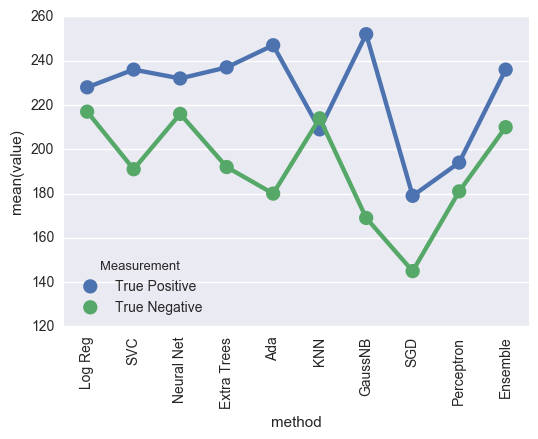

In [59]:
p = sns.pointplot(x="method", y="value", hue="Measurement", data=mm1_eval)
labs = list(m_eval['method'])
p.set_xticklabels(labs, rotation=90);

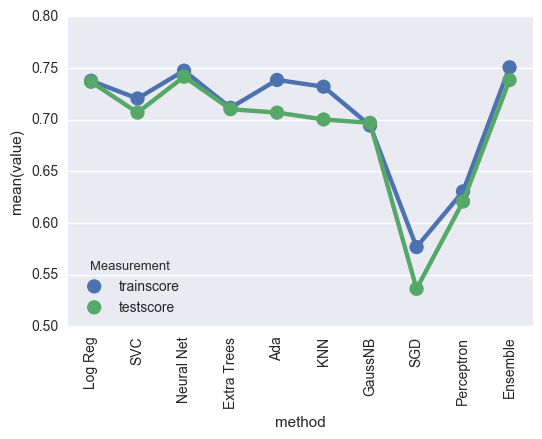

In [60]:
p = sns.pointplot(x="method", y="value", hue="Measurement", data=mm2_eval)
labs = list(m_eval['method'])
p.set_xticklabels(labs, rotation=90);

# Calculate LogLoss#
Composite =  a combination of SVC to predict **losses** and Gaussian Naive Bayes to predict **wins**

X = X.drop('result',axis = 1)
X.head(1)

In [61]:
svc_target = pd.DataFrame(svc.predict_proba(xx),columns = ['predicted','inverse'])
gauss_target = pd.DataFrame(gauss.predict_proba(xx),columns = ['predicted','inverse'])
nn_target = pd.DataFrame(nn.predict_proba(xx),columns = ['predicted','inverse'])
ens_target = pd.DataFrame(ens.predict_proba(xx),columns = ['predicted','inverse'])

In [62]:
low = 0.01
high = 0.99

X['log_pred'] = minmax_scale(svc_target['inverse'],feature_range=(low,high))
X['svc_pred'] = minmax_scale(svc_target['inverse'],feature_range=(low,high))
X['gauss_pred'] = minmax_scale(gauss_target['inverse'], feature_range=(low,high))
X['nn_pred'] = minmax_scale(nn_target['inverse'], feature_range=(low,high))
X['ens_pred'] = minmax_scale(ens_target['inverse'], feature_range=(low,high))

In [63]:
X['result'] = y

Calculate the Log Loss score

In [64]:
print('Log Reg Log Loss Score: ' + str(log_loss(X['result'],X['ens_pred'])))
print('SVC Log Loss Score: ' + str(log_loss(X['result'],X['svc_pred'])))
print('Gauss Log Loss Score: ' + str(log_loss(X['result'],X['gauss_pred'])))
print('Neural Net Log Loss Score: ' + str(log_loss(X['result'],X['nn_pred'])))
print('Ensemble Log Loss Score: ' + str(log_loss(X['result'],X['ens_pred'])))

Log Reg Log Loss Score: 0.506755856961
SVC Log Loss Score: 1.2951775364
Gauss Log Loss Score: 1.08745020434
Neural Net Log Loss Score: 0.516373317269
Ensemble Log Loss Score: 0.506755856961


**Calculate composite predictions**

   If the Gaussian model predicts a win with more confidence than the SVC model predicts a loss, return a win.
   If the SVC model predicts a loss with more confidence than the Gaussian model predicts a win, return a loss.

In [65]:
x1 = X[['svc_pred','nn_pred','result']]
x1['svc_strngth'] = 0.5 - x1['svc_pred']
x1['nn_strngth'] = x1['nn_pred']-0.5

In [66]:
def calcrow(df):
    if (df['svc_strngth']>0 and df['svc_strngth'] > df['nn_strngth']):
        return "SVC"
    else:
        return "NN"
        
def scorerow(df):
    if df['cmpst'] == "SVC":
        return df['svc_pred']
    else:
        return df['nn_pred']

In [67]:
x1['cmpst'] = x1.apply(calcrow,axis = 1)
x1['cmpst_pred'] = x1.apply(scorerow,axis =1)

In [68]:
X['cmpst_pred'] = x1['cmpst_pred']

print('SVC Log Loss Score: ' + str(log_loss(X['result'],X['svc_pred'])))
print('Gauss Log Loss Score: ' + str(log_loss(X['result'],X['gauss_pred'])))
print('Neural Net Log Loss Score: ' + str(log_loss(X['result'],X['nn_pred'])))
print('Ensemble Log Loss Score: ' + str(log_loss(X['result'],X['ens_pred'])))
print('Composite Log Loss Score: ' + str(log_loss(X['result'],X['cmpst_pred'])))

SVC Log Loss Score: 1.2951775364
Gauss Log Loss Score: 1.08745020434
Neural Net Log Loss Score: 0.516373317269
Ensemble Log Loss Score: 0.506755856961
Composite Log Loss Score: 0.812272753499


Composite Predictor did **not** prove to be better than the Neural Net by itself

**Precision, Recall, Accuracy**

In [69]:
x1 = X.ix[:,:len(X.columns)-7]
a1 = lr.predict(x1)
a = svc.predict(x1)
b = nn.predict(x1)
c = gauss.predict(x1)
d = etc.predict(x1)
e = sgd.predict(x1)
f = perc.predict(x1)
g = ada.predict(x1)
h = knn.predict(x1)
i = ens.predict(x1)

predictions = list([a1,a,b,c,d,e,f,g,h,i])
models = ['Log Reg','SVC','NN','Gauss','ETC','SGD','Perc','Ada','KNN','Ensemble']

scores = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall'])

y = 0
while y < len(predictions):
    y1 = accuracy_score(X['result'],predictions[y])
    y2 = precision_score(X['result'],predictions[y])
    y3 = recall_score(X['result'],predictions[y])
    
    y4 = models[y]
    d = pd.DataFrame([[y4,y1,y2,y3]],columns = ['Model','Accuracy','Precision','Recall'])
    scores = scores.append(d)
    y=y+1

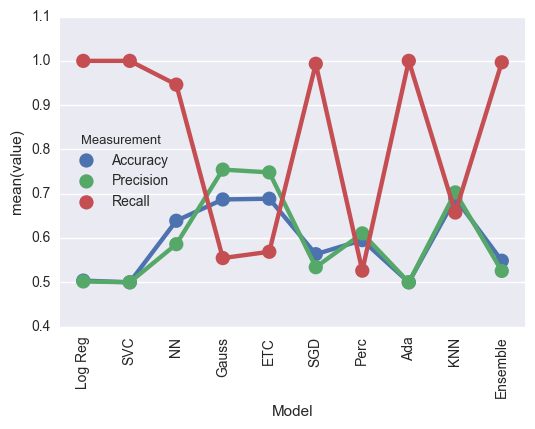

In [70]:
m_s = pd.melt(scores, "Model", var_name="Measurement")
p = sns.pointplot(x="Model", y="value", hue="Measurement", data=m_s)
labs = list(m_s['Model'])
p.set_xticklabels(labs, rotation=90);

In [71]:
x1 = X.ix[:,:len(X.columns)-6]
a1 = lr.predict_proba(xx)[:,1] 
a = svc.predict_proba(xx)[:,1]
b = nn.predict_proba(xx)[:,1]
c = gauss.predict_proba(xx)[:,1]
d = etc.predict_proba(xx)[:,1]
e = sgd.predict_proba(xx)[:,1]
#f = perc.predict_proba(x1)[:,1]
g = ada.predict_proba(xx)[:,1]
h = knn.predict_proba(xx)[:,1]
i = ens.predict_proba(xx)[:,1]

predictions = list([a1,a,b,d,g,h,i])
models = ['Log Reg','SVC','NN','ETC','Ada','KNN','Ensemble']

ll = pd.DataFrame(columns = ['Model','Log Loss'])

y = 0
while y < len(predictions):
    y1 = log_loss(X['result'],predictions[y])
    y4 = models[y]
    dd = pd.DataFrame([[y4,y1]],columns = ['Model','Log Loss'])
    ll = ll.append(dd)
    y=y+1
    
ll

,Model,Log Loss
0,Log Reg,0.512860
0,SVC,0.594823
0,NN,0.517994
0,ETC,0.564791
0,Ada,0.644041
0,KNN,0.557126
0,Ensemble,0.513521


In [72]:
scores = pd.merge(scores, ll, how = 'left', left_on = 'Model',right_on = 'Model')
scores

,Model,Accuracy,Precision,Recall,Log Loss
0,Log Reg,0.503829,0.501922,1.000000,0.512860
1,SVC,0.500000,0.500000,1.000000,0.594823
2,NN,0.638950,0.586043,0.946389,0.517994
3,Gauss,0.687090,0.754464,0.554705,NaN
4,ETC,0.688731,0.748201,0.568928,0.564791
5,SGD,0.563457,0.534118,0.993435,NaN
6,Perc,0.595186,0.610406,0.526258,NaN
7,Ada,0.500000,0.500000,1.000000,0.644041
8,KNN,0.689825,0.702924,0.657549,0.557126
9,Ensemble,0.548687,0.525678,0.996718,0.513521


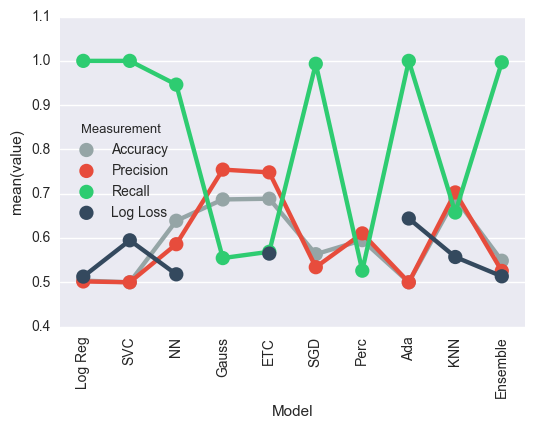

In [73]:
flatui = ["#95a5a6", "#e74c3c","#2ecc71","#34495e"]

m_s = pd.melt(scores, "Model", var_name="Measurement")
p = sns.pointplot(x="Model", y="value", hue="Measurement", data=m_s, palette = flatui)
labs = list(m_s['Model'])
p.set_xticklabels(labs, rotation=90);

In [74]:
mod = pd.DataFrame(a1, columns = ['Log Reg'])
mod['SVM'] = a
mod['Neural Net'] = b
mod['Gaussian NB'] = c
mod['Extra Trees'] = d
mod['SGD'] = e
mod['Adaptive Boost'] = g
mod['KNN'] = g
mod['Ensemble'] = i
mod['Result'] = X['result']
mod.head()

,Log Reg,SVM,Neural Net,Gaussian NB,Extra Trees,SGD,Adaptive Boost,KNN,Ensemble,Result
0,0.435961,0.696903,0.396865,0.888865,0.636417,1.000000,0.509174,0.509174,0.479387,1
1,0.986024,0.697140,0.913213,1.000000,0.650836,1.000000,1.000000,1.000000,0.916703,1
2,0.913417,0.697178,0.864034,0.941556,0.625789,0.738770,0.714286,0.714286,0.828469,1
3,0.421315,0.261585,0.431480,0.059813,0.487531,1.000000,0.671875,0.671875,0.438965,1
4,0.642676,0.697042,0.639368,0.999187,0.650836,0.564452,0.509174,0.509174,0.629285,1


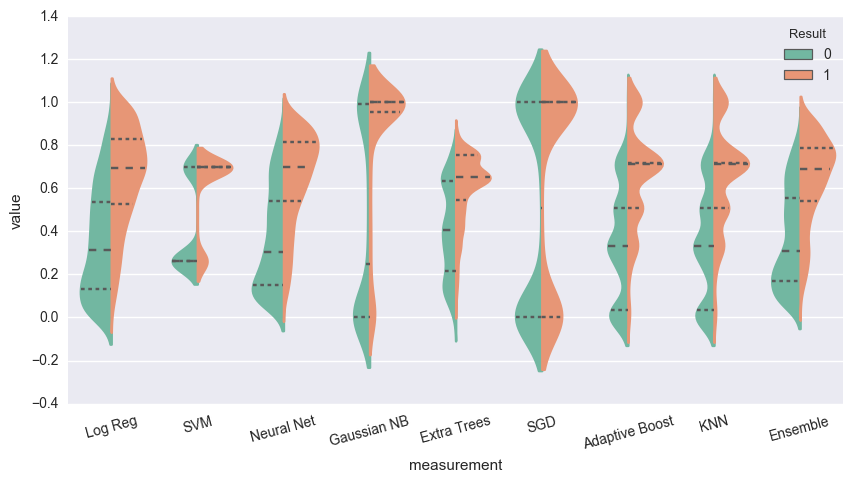

In [75]:
m_mod = pd.melt(mod, "Result", var_name="measurement")

fig, ax = plt.subplots(figsize=(10,5))
p = sns.violinplot(ax=ax, x="measurement", y="value", split = True, data=m_mod, inner = 'quartile', palette = 'Set2', hue = 'Result')
#p = sns.swarmplot(data=mod)
p.set_xticklabels(rotation = 15,labels = mod.columns);
pf = p.get_figure()

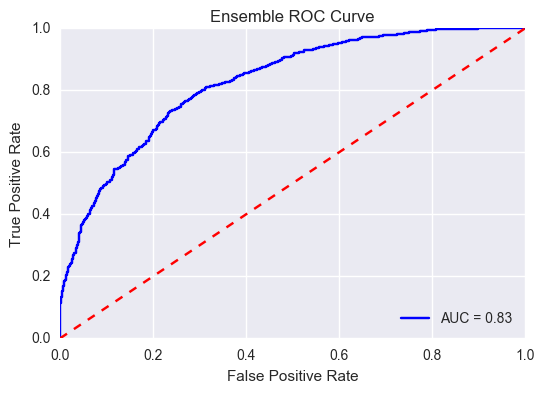

In [76]:
fpr, tpr, thresholds = roc_curve(X['result'],X['ens_pred'])
roc_auc = auc(fpr, tpr)
plt.title('Ensemble ROC Curve')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

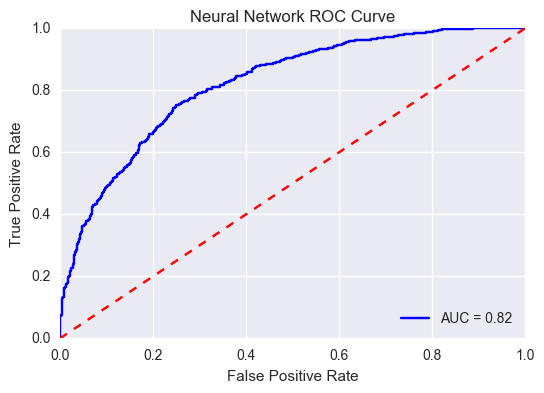

In [77]:
fpr, tpr, thresholds = roc_curve(X['result'],X['nn_pred'])
roc_auc = auc(fpr, tpr)
plt.title('Neural Network ROC Curve')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

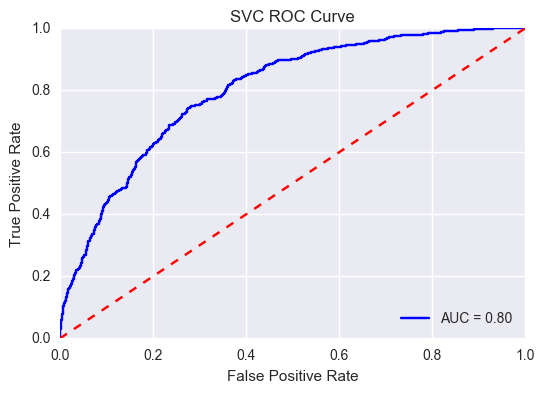

In [78]:
fpr, tpr, thresholds = roc_curve(X['result'],X['svc_pred'])
roc_auc = auc(fpr, tpr)
plt.title('SVC ROC Curve')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

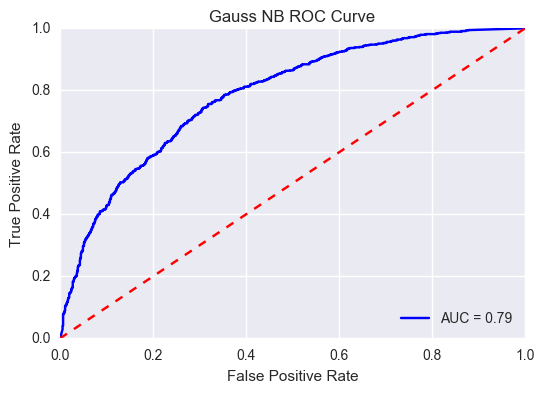

In [79]:
fpr, tpr, thresholds = roc_curve(X['result'],X['gauss_pred'])
roc_auc = auc(fpr, tpr)
plt.title('Gauss NB ROC Curve')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

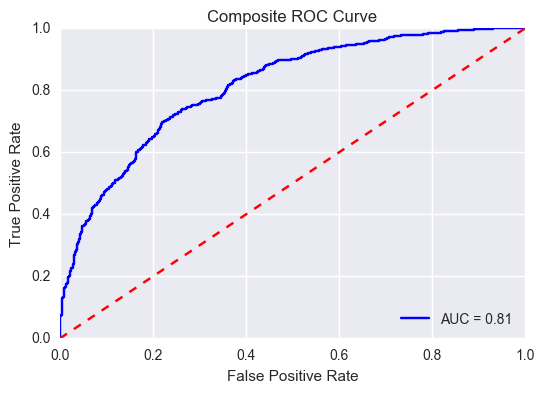

In [80]:
fpr, tpr, thresholds = roc_curve(X['result'],X['cmpst_pred'])
roc_auc = auc(fpr, tpr)
plt.title('Composite ROC Curve')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [81]:
games['ens'] = X['ens_pred']

games.to_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\2017\\StatVis.csv')

**Predict All Possible Matchups**

In [82]:
pred = pd.read_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\2017\\Pred.csv')
pred['r_adjseed'] = pred['r_adjseed'] * -1
pred['r_seed'] = pred['r_seed'] * -1
#pred = pred.drop('r_seed', axis = 1)
#pred = pred.drop('r_seeddiff', axis = 1)

In [83]:
years = [2017]

In [84]:
pred.columns

Index(['﻿Year', 'Team1', 'Team2', 'id', 'r_seeddiff', 'tournwin% ', 'r_seed',
       'r_1rpi', 'r_adjseed', 'r_1adjrpi', 'r_ascore', 'r_agscore', 'r_Av fg%',
       'r_Av fg3%', 'r_Av ft%', 'r_1or', 'r_1dr', 'r_1ast', 'r_1to', 'r_1stl',
       'r_1blk', 'r_1pf', 'r_Av 2fg%', 'r_Av 2fg3%', 'r_Av 2ft%', 'r_2or',
       'r_2dr', 'r_2ast', 'r_2to', 'r_2stl', 'r_2blk', 'r_2pf', 'r_tempo',
       'r_adjtempo', 'r_oe', 'r_adjoe', 'r_de', 'r_adjde'],
      dtype='object')

In [85]:
feats = ['r_seed',
 'r_1rpi',
 'r_adjde',
 'r_1adjrpi',
 'r_1dr',
 'r_Av 2ft%',
 'r_2or',
 'r_1ast',
 'r_oe',
 'r_ascore',
 'r_adjseed',
 'r_Av fg%']
predu = pred[feats]

predu = uscaler.transform(predu)  

ensu_target = pd.DataFrame(ensu.predict_proba(predu),columns = ['predicted','inverse'])
pred['upset_pred'] = ensu_target['inverse']
pred['game_pred'] = pred.apply(predupset,axis = 1)
pred.ix[:,4:].columns

Index(['r_seeddiff', 'tournwin% ', 'r_seed', 'r_1rpi', 'r_adjseed',
       'r_1adjrpi', 'r_ascore', 'r_agscore', 'r_Av fg%', 'r_Av fg3%',
       'r_Av ft%', 'r_1or', 'r_1dr', 'r_1ast', 'r_1to', 'r_1stl', 'r_1blk',
       'r_1pf', 'r_Av 2fg%', 'r_Av 2fg3%', 'r_Av 2ft%', 'r_2or', 'r_2dr',
       'r_2ast', 'r_2to', 'r_2stl', 'r_2blk', 'r_2pf', 'r_tempo', 'r_adjtempo',
       'r_oe', 'r_adjoe', 'r_de', 'r_adjde', 'upset_pred', 'game_pred'],
      dtype='object')

In [86]:
#pred = pred[(pred['Year'].isin(years))]

pred1 = pred.ix[:,4:]
pred1 = scalerclust.transform(pred1)

In [87]:
clust = kmeans.predict(pred1)
pred['Clust'] = clust
set(clust)

{0, 1, 2, 4}

In [88]:
pred1 = pred.ix[:,4:]
pred1 = scaler.transform(pred1)

In [89]:
p = pd.DataFrame(nn.predict_proba(pred1),columns = ['predicted','inverse'])
q = pd.DataFrame(svc.predict_proba(pred1),columns = ['predicted','inverse'])
r = pd.DataFrame(ens.predict_proba(pred1),columns = ['predicted','inverse'])
s = pd.DataFrame(ens.predict(pred1), columns = ['winner'])

In [90]:
len(pred1),len(p)

(2278, 2278)

In [91]:
pred['nn_pred'] = p['inverse']
pred['svc_pred'] = q['inverse']
pred['ens_pred'] = r['inverse']
pred['ens_bool'] = s['winner']

x1 = pred[['svc_pred','nn_pred']]
x1['svc_strngth'] = 0.5 - x1['svc_pred']
x1['nn_strngth'] = x1['nn_pred']-0.5

x1['cmpst'] = x1.apply(calcrow,axis = 1)
x1['cmpst_pred'] = x1.apply(scorerow,axis =1)

pred['cmpst_pred'] = x1['cmpst_pred']

pred['scale'] = minmax_scale(pred['nn_pred'], feature_range=(low,high),axis = 0, copy = True)
pred.head()

,﻿Year,Team1,Team2,id,r_seeddiff,tournwin%,r_seed,r_1rpi,r_adjseed,r_1adjrpi,...,r_adjde,upset_pred,game_pred,Clust,nn_pred,svc_pred,ens_pred,ens_bool,cmpst_pred,scale
0,2017,1411,1413,2017_1411_1413,1,0.0,0,1.053571,1,1.031206,...,1.045384,0.066560,1,4,0.791915,0.697038,0.763511,1,0.791915,0.847181
1,2017,1411,1417,2017_1411_1417,1,0.0,-13,0.850962,-12,0.808824,...,1.074911,0.133007,1,2,0.386158,0.696789,0.393043,0,0.386158,0.363729
2,2017,1411,1423,2017_1411_1423,-3,0.0,-4,0.882060,-7,0.853747,...,1.018005,0.073543,1,4,0.377002,0.696898,0.425773,0,0.377002,0.352820
3,2017,1411,1425,2017_1411_1425,-1,0.0,-5,0.904600,-6,0.858831,...,1.071007,0.129029,1,2,0.313180,0.696827,0.377773,0,0.313180,0.276777
4,2017,1411,1433,2017_1411_1433,-2,0.0,-6,0.864821,-8,0.844161,...,1.127612,0.128227,1,4,0.368656,0.696878,0.413524,0,0.368656,0.342876


In [92]:
#ENS no scale has best score
pred[['id','ens_pred']].to_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\Predictions\\Kaggle11.csv')

In [93]:
teams = pd.read_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\2017\\Teams.csv')
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
Team_Id      364 non-null int64
Team_Name    364 non-null object
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [94]:
prob = pred[['id','Team1','Team2','ens_pred','ens_bool']]

prob = pd.merge(prob, teams, how = 'left', left_on = 'Team1', right_on = 'Team_Id')
prob = pd.merge(prob, teams, how = 'left', left_on = 'Team2', right_on = 'Team_Id')

prob = prob.drop('Team_Id_x',axis =1)
prob = prob.drop('Team_Id_y',axis =1)

In [95]:
prob.to_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\Predictions\\Presentation.csv')

In [96]:
cnt = pd.pivot_table(prob, values='ens_bool', index='Team_Name_x', columns=None, aggfunc='sum')

In [97]:
stat = pd.read_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\2017\\Stats.csv')

In [98]:
win = stat[stat['\ufeffResult'] == 'Win']
loss = stat[stat['\ufeffResult'] == 'Loss']

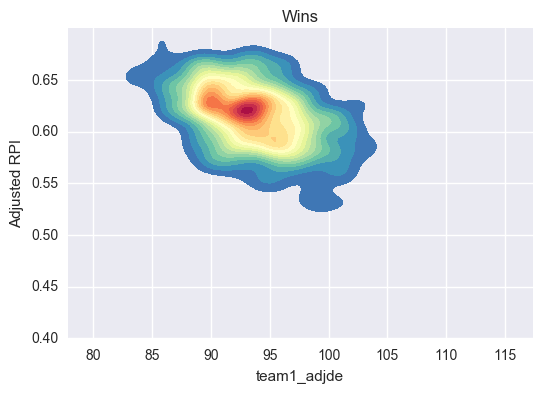

In [99]:
p = sns.kdeplot(win['team1_adjde'], win['Adjusted RPI'],cmap="Spectral_r", 
                shade=True, shade_lowest=False, size = 10, aspect = 'equal',kind = 'kde',n_levels=25)
plt.ylim(.4, .7)
#plt.xlim(.4, .7)
plt.title('Wins')
#plt.figsize=(6, 6)
#p.set_xlabels("Tip",size = 50,color="r",alpha=0.5)
pf = p.get_figure()
#pf.savefig("awin.png", dpi = 2000)

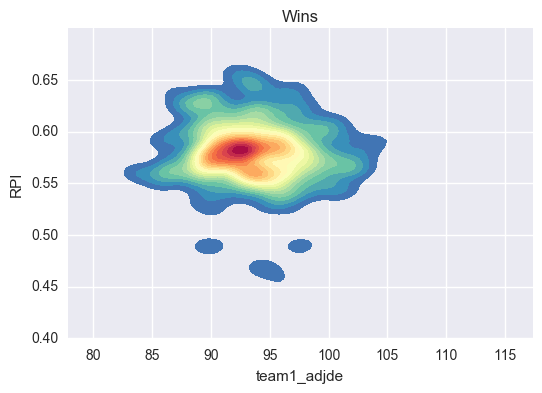

In [100]:
win = stat[stat['\ufeffResult'] == 'Win']
loss = stat[stat['\ufeffResult'] == 'Loss']
p = sns.kdeplot(win['team1_adjde'], win['RPI'],cmap="Spectral_r", 
                shade=True, shade_lowest=False, size = 10, aspect = 'equal',kind = 'kde',n_levels=25)
plt.ylim(.4, .7)
plt.title('Wins')
pf = p.get_figure()

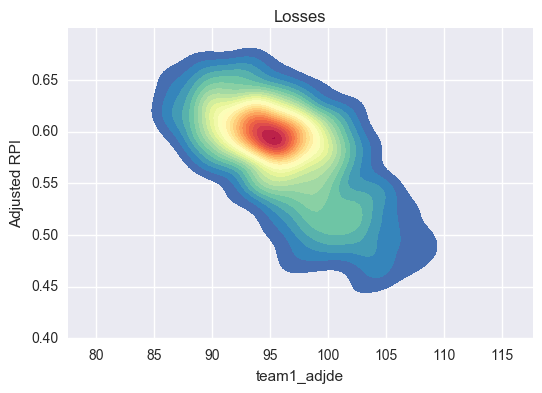

In [101]:

p = sns.kdeplot(loss['team1_adjde'], loss['Adjusted RPI'],cmap="Spectral_r", 
                shade=True, shade_lowest=False,size = 10, aspect = 'equal',n_levels=25)
pf = p.get_figure()
plt.ylim(.4, .7)
plt.title('Losses')

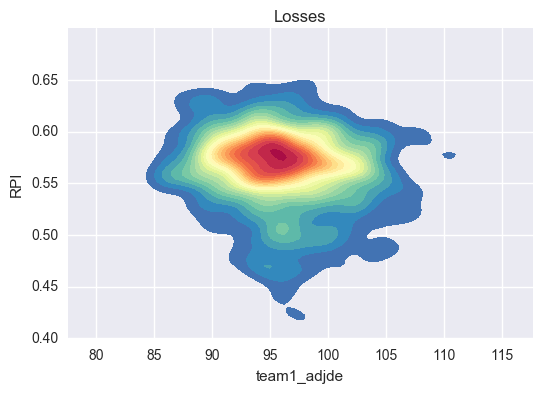

In [102]:
p = sns.kdeplot(loss['team1_adjde'], loss['RPI'],cmap="Spectral_r", 
                shade=True, shade_lowest=False,size = 10, aspect = 'equal',n_levels=25)
pf = p.get_figure()
plt.ylim(.4, .7)

plt.title('Losses')

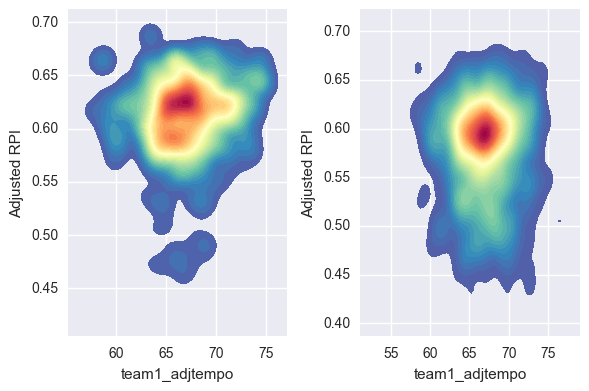

In [103]:
fig = plt.figure()
ax = fig.add_subplot(aspect='equal')

plt.subplot(1, 2, 1)
sns.kdeplot(win['team1_adjtempo'], win['Adjusted RPI'],cmap="Spectral_r", 
            shade=True, shade_lowest=False, size = 5, aspect = 10,n_levels=50)

plt.subplot(1, 2, 2)
sns.kdeplot(loss['team1_adjtempo'], loss['Adjusted RPI'],cmap="Spectral_r", 
            shade=True, shade_lowest=False,size = 5,aspect = 10,n_levels=50)

plt.tight_layout()
plt.show()

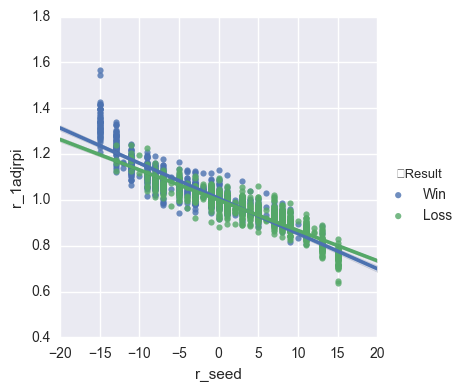

In [104]:
sns.lmplot(x = 'r_seed', y = 'r_1adjrpi',  hue='\ufeffResult', size = 4, data = stat);